In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import webrtcvad
import wave
import speech_recognition as sr           # package SpeechRecognition
import datetime
import strsimpy
import xml.etree.ElementTree as ET
import soundfile as sf
from pydub import AudioSegment
from pydub.silence import split_on_silence
import os
from scipy import ndimage

#### Ouverture du csv des annotations, changement des colonnes

In [2]:
samplerate = 16000

directory = './challenge-m2-sid/'
dir_audio = directory + 'corpus/audio/'
dir_texte = directory + 'corpus/text/'
dir_video = directory + 'corpus/video/'

audio_extension = "_mono.wav"
texte_extension = ".xml"
video_extension = ".m4v"

annot = pd.read_csv(directory+'annotations_challenge_sid.csv', sep="\t", index_col=0, header=0).replace(-1,np.nan)
noteurs = annot.columns[1:]

annot['doc']      = ["_".join(e.split("_")[0:2]) for e in annot["code_doc"]]
annot['audio']    = [int(e.split("_")[2][0])     for e in annot["code_doc"]]
annot['video']    = [int(e.split("_")[2][1])     for e in annot["code_doc"]]
annot['texte']    = [int(e.split("_")[2][2])     for e in annot["code_doc"]]
annot['isGraded'] = [int(e.split("_")[3])        for e in annot["code_doc"]]

annot = annot.drop("code_doc", axis=1)
annot.head(6)

,il08_09,vg04_05,fd03_04,la09_10,cg13_14,mb00_12,doc,audio,video,texte,isGraded
1,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,1,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,1,1,0
4,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,0,1,0
5,NaN,NaN,NaN,NaN,NaN,NaN,119_8,0,0,1,0
6,NaN,NaN,NaN,NaN,NaN,76.0,57_6,1,0,0,1


#### Selection des audio notés et calcul de la moyenne

In [3]:
audio_only = annot[(annot['isGraded'] == 1) &
                   (annot['audio']    == 1) &
                   (annot['video']    == 0) &
                   (annot['texte']    == 0)
                  ].copy()

audio = annot[(annot['isGraded'] == 1) & 
              (annot['audio']    == 1)
             ].copy()

audio['moyenne']      = audio[noteurs].apply(np.nanmean, axis=1)
audio_only['moyenne'] = audio_only[noteurs].apply(np.nanmean, axis=1)

print("audio :",      len(set(audio['doc'])))
print("audio_only :", len(set(audio_only['doc'])))

audio_only[['doc','moyenne']].groupby(['doc']).agg(['count','mean']).head(7)

audio : 55
audio_only : 33


moyenne      
        count  mean
doc                
100_1       1  47.5
107_7       1  76.0
108_3       1  66.0
128_5       1  81.0
13_2        1  62.5
147_1       1  64.0
148_4       1  13.0

#### liste des fichiers audio annotés

In [4]:
ratedScenes = sorted(list(set(audio['doc'])))
print(ratedScenes[0:10])

['100_1', '107_7', '108_3', '116_15', '128_5', '129_5', '12_13', '13_2', '147_1', '148_4']


### Librairies : Pybk, webTRC, SNR, énergie, ZCR, MFCC
score de reconnaissance son texte avec le CMU sphinx  
nombre de locuteurs en tout (et en même temps)  
SNR  
ligth gradient boosting (si pb de corrélation)  
accent ?  
lium speaker diarization (java) -> nombre de locuteur, (~segmentation parole/non parole)  





In [10]:
# loading signal
def load_signal(file, samplerate=16000):
    signal, fe = librosa.load(file, sr=samplerate, mono=True)
    
    w = wave.open(file, "rb")
    binary_data = w.readframes(w.getnframes())
    
    return binary_data, signal, fe

# speech detection using webrtcvad
def get_speech_intervals(bin_signal, samplerate=16000, agg=3, smooth='closing', affichage=False):
    recomposed_signal = np.frombuffer(bin_signal, dtype=np.int16)

    vad = webrtcvad.Vad()
    vad.set_mode(mode=agg)

    millisec = 10
    fenetre = int(samplerate * millisec * 2 / 1000)

    fen_speech = [vad.is_speech(bin_signal[m:m+fenetre], samplerate) 
                  for m in range(0,len(bin_signal),fenetre)
                 if len(bin_signal[m:m+fenetre]) == fenetre]

    widened_speech = np.array([[s] * int(fenetre/2) for s in fen_speech]).ravel()
    speech = np.full(len(recomposed_signal), widened_speech[-1])
    speech[0:len(widened_speech)] = widened_speech

    # adoucissement
    if smooth == 'closing':
        smoothed_speech = ndimage.binary_closing(input=speech, structure=np.array([1]*10000)).astype(bool)
    elif smooth == 'rolling_mean' :
        smoothed_speech = pd.Series(speech).rolling(window=int(samplerate/5), min_periods=2, center=True).mean() > 0.2
    
    
    if affichage :
        plt.figure(figsize=(14,4))
        plt.plot(np.arange(len(smoothed_speech))/samplerate, smoothed_speech*max(recomposed_signal), label="speech")
        plt.plot(np.arange(len(recomposed_signal))/samplerate, recomposed_signal, label="signal")
        plt.xlabel("sec")
        plt.legend(loc=4)
        plt.show()
        
    return pd.Series(smoothed_speech)

# SNR using speech detection (bad on recomposed signal from binary)
def get_SNR(signal, speech, samplerate=16000):
    s = pd.Series(signal)
    energy_total = (s**2).rolling(window=samplerate, min_periods=2, center=True).mean()

    energy_speech = (s[speech]**2).rolling(window=samplerate, min_periods=2, center=True).mean()
    energy_notSpeech = (s[~speech]**2).rolling(window=samplerate, min_periods=2, center=True).mean()

    SNR = energy_speech.mean() / (energy_speech.mean() + energy_notSpeech.mean())
    
    return SNR

# return text sentence from audio
def get_recognition(audiofile, adjust_noise=False):
    r  = sr.Recognizer()
    demo = sr.AudioFile(audiofile)
    with demo as source:
        if adjust_noise: r.adjust_for_ambient_noise(source)
        audio = r.record(source)
    try:
        recon = r.recognize_google(audio, language='fr-FR', show_all=True)
        if len(recon) == 0 :
            text = ''
            conf = 0
        else :
            text = recon['alternative'][0]['transcript']
            conf = recon['alternative'][0]['confidence']
    except LookupError:
        print("LookupError : Could not understand audio")
        text = ''
        conf = 0
    
    return conf, text

# return sentences, when they start in seconds and their length in seconds
def get_timed_sentences(xmlfile):
    tree = ET.parse(xmlfile)

    sentences = [([e.attrib['value'] for e in sent if e.tag=='time'],
                  " ".join([w.text.strip() for w in sent if w.text is not None]))
                 for sent in tree.getroot()]

    t0 = datetime.datetime.strptime(sentences[0][0][0], '%H:%M:%S,%f')
    for i,(t,s) in enumerate(sentences):
        t1 = datetime.datetime.strptime(t[0], '%H:%M:%S,%f')
        t2 = datetime.datetime.strptime(t[1], '%H:%M:%S,%f')
        sentences[i] = (((t1 - t0).total_seconds() , (t2 - t1).total_seconds()),s)

    return sentences

# split tthe speech signal (0/1) into several signal (1)
def split_speech(speech, samplerate=16000, sec_before=1, sec_after=0.5):
    f = np.array([1,-1])
    r = np.convolve(speech, f, 'same')
    starts, ends = np.where(r == 1)[0].tolist(), np.where(r == -1)[0].tolist()
    if ends[0] < starts[0] : starts = [0] + starts
    if len(starts) > len(ends) : ends = ends + [len(speech)]

    speech_intervals = np.array([(0,
                                  starts[i] - int(samplerate*sec_before),
                                  starts[i],
                                  ends[i], ends[i] + int(samplerate*sec_after))
                                 for i in range(len(starts))])

    diffs = [(v[2] - speech_intervals[i][-2] - int(samplerate*sec_before)) for i,v in enumerate(speech_intervals[1:])]
    diffs = [0 if speech_intervals[0,1] > 0 else -speech_intervals[0,1]] + [0 if v > 0 else abs(v) for v in diffs]

    speech_intervals[:,0] = diffs
    speech_intervals[:,1] += speech_intervals[:,0]
    speech_intervals[speech_intervals < 0] = 0

    df_intervals = pd.DataFrame(speech_intervals,
                                columns=['add_noise','start_signal','start_speech','end_speech','end_signal'])
    return df_intervals

# return bool signal where the background noise is
def get_background(signal, speech, samplerate, affichage=False):
    background = speech.rolling(window=int(samplerate/4), center=True).mean() < 1/10
    
    if affichage:
        plt.figure(figsize=(14,4))
        plt.plot(signal, label="signal")
        plt.plot(speech * max(signal) / 2, label="speech")
        plt.plot(background * max(signal), label="noise")
        plt.legend(loc=4)
        plt.show()
        
    return background

# make noise from signal and background
def make_noise(signal, background, samplerate, lenght=3):
    if background.sum() < samplerate/10 :
        noise = signal[:len(signal) - len(signal)%samplerate].reshape(samplerate, int(len(signal)/samplerate)).mean(axis=1)
    else :
        noise = np.array([signal[background][m:m+int(lenght*samplerate)]
                          for m in range(len(signal[background][::int(lenght*samplerate)]))]).mean(axis=0)
        if len(noise) < lenght*samplerate:
            noise = np.array(list(noise) * (int(lenght*samplerate / len(noise))+1))[0:int(lenght*samplerate)]
    return noise

def get_dB_treshold(dB, n_win_wanted=11, affichage=False):
    dBs = list(range(50,100))
    res = pd.Series(0, index=dBs)

    for v_dB in dBs:
        d = np.array(dB) + v_dB
        r = (d > 0)

        taille = 1
        f = np.array([1,1]) / 2
        c = (np.convolve(r,f,'same') < 0.8)

        f2 = np.array([-1,1])
        c2 = np.convolve(c,f2,'same')
        res[v_dB] = sum(c2==max(c2))

        if affichage:
            plt.figure(figsize=(14,3))
            plt.plot(d, alpha=0.5)
            plt.plot(c2 * max(d), alpha=0.5)
            plt.show()
    
    treshold = min(list(res.items()), key=lambda x: abs(x[1]-n_win_wanted))[0]
    return treshold

def get_chunks(audiofile, samplerate=16000, method='speech', smooth='closing', speech=None):
    song = AudioSegment.from_wav(audiofile)
    
    if method == 'silence': 
        # split track where silence is quieter than the threshold in dBFS for x milliseconds
        fen = 300
        dB = [song[i:i+fen].dBFS for i in range(0,len(song),fen)]
        treshold = get_dB_treshold(dB, n_win_wanted=11, affichage=False)
        chunks = split_on_silence(song, min_silence_len=100, silence_thresh=-treshold)
    
    elif method == 'speech':
        # split track based on speech detection
        bin_signal, signal, fe = load_signal(audiofile, samplerate=samplerate)
        if speech is None :
            print("MAKE SPEECH AGAIN")
            speech = get_speech_intervals(bin_signal, samplerate=fe, agg=3, smooth=smooth, affichage=False)
        df_intervals = split_speech(speech, sec_before=0.8, sec_after=0.3)
        chunks_sep = [(int(df_intervals.loc[i,'start_speech']/samplerate*1000),
                       int(df_intervals.loc[i,'end_speech']/samplerate*1000))
                      for i in range(len(df_intervals))]
        chunks = [song[cs[0]:cs[1]] for cs in chunks_sep]
        
    elif method == 'stable_cuts':
        bin_signal, signal, fe = load_signal(audiofile, samplerate=samplerate)
        df_intervals = pd.DataFrame(columns=['add_noise','start_signal','start_speech','end_speech','end_signal'])
        cuts = pd.Series(signal)[::samplerate*5].index
        for i,ci in enumerate(cuts):
            df_intervals.loc[i,'add_noise'] = samplerate
            df_intervals.loc[i,'start_signal'] = ci
            df_intervals.loc[i,'start_speech'] = ci
            df_intervals.loc[i,'end_speech'] = min(len(signal), ci+samplerate*10)
            df_intervals.loc[i,'end_signal'] = min(len(signal), ci+samplerate*10)
        chunks_sep = [(int(df_intervals.loc[i,'start_speech']/samplerate*1000),
                       int(df_intervals.loc[i,'end_speech']/samplerate*1000))
                      for i in range(len(df_intervals))]
        chunks = [song[cs[0]:cs[1]] for cs in chunks_sep]
        
    listenable_chunks = [c for c in chunks if len(c) > 300]
    return listenable_chunks

def make_write_get_noise(audiofile, samplerate=16000, duration=500, smooth='closing', speech=None):
    bin_signal, signal, fe = load_signal(audiofile, samplerate=samplerate)
    if speech is None :
        speech = get_speech_intervals(bin_signal, samplerate=fe, agg=3, smooth=smooth, affichage=False)
    background = get_background(signal, speech, fe, affichage=False)
    noise = make_noise(signal, background, fe, lenght=duration/1000)
    filename = './audio_chunks/noise.wav'
    sf.write(filename, noise, samplerate=fe, subtype='PCM_16')
    noise = AudioSegment.from_wav(filename)
    return noise

# text from audio file using google recognizer
def recon(audiofile, method='speech', smooth='closing', speech=None):
    song = AudioSegment.from_wav(audiofile) 
    
    # create chunks
    listenable_chunks = get_chunks(audiofile, samplerate=samplerate, method=method, smooth=smooth, speech=speech)
    
    # noise and silence creation
    chunk_noise  = make_write_get_noise(audiofile, samplerate=16000, duration=500, smooth=smooth, speech=speech)
    chunk_silent = AudioSegment.silent(duration=500)

    # create a directory to store the audio chunks.
    try: os.mkdir('./audio_chunks') 
    except(FileExistsError): pass
    
    overall_conf = []
    overall_text = ''
    for i,chunk in enumerate(listenable_chunks):
        
        # add 500 milliseconds silence and raise the volume by 16 dB
        audio_chunk = chunk_silent + (chunk + 16) + chunk_silent
        # or add 500 milliseconds of noise and raise the volume by 16 dB
        audio_chunk = chunk_noise + (chunk + 16) + chunk_noise
        
        # save the newly created chunk
        filename = './audio_chunks/chunk'+str(i)+'.wav'
        audio_chunk.export(filename, bitrate ='192k', format ="wav") 

        # recognize the chunk
        r = sr.Recognizer()
        with sr.AudioFile(filename) as source: 
            audio_listened = r.record(source) 
        try:
            rec = r.recognize_google(audio_listened, language='fr-FR', show_all=True)
            if len(rec) == 0 : 
                conf = 0
                text = ''
            else :
                if 'confidence' in rec['alternative'][0]: conf = rec['alternative'][0]['confidence']
                else : conf = np.nan
                text = rec['alternative'][0]['transcript']
            
            overall_text += ' ' + text
            overall_conf.append(conf)
        except sr.UnknownValueError: print("-- Could not understand audio") 
        except sr.RequestError as e: print("-- Could not request results. check your internet connection")
    
    overall_text = " ".join(overall_text.split())
    overall_conf = np.array(overall_conf)[np.array(overall_conf) != 0].mean()
    
    return overall_conf, overall_text

# get features from a scene
def extract_features(scene, method='speech', smooth='closing'):
    audiofile = dir_audio + scene + audio_extension
    xmlfile   = dir_texte + scene + texte_extension
    
    # load data
    bin_signal, signal, fe = load_signal(audiofile, samplerate=samplerate)

    # speech intervals
    speech = get_speech_intervals(bin_signal, samplerate=fe, agg=3, smooth=smooth, affichage=False)
    SR = speech.sum()/len(speech)

    # SNR (from speech data)
    SNR = get_SNR(signal, speech, samplerate=fe)
    
    # xml to text
    sentences = get_timed_sentences(xmlfile)
    sent_ponct = " ".join([s[1] for s in sentences])
    sent = " ".join("".join([x if x.isalpha() else " " for x in sent_ponct]).split())
    
    # audio to text
    conf, text = recon(audiofile, method=method, smooth=smooth, speech=speech)
    
    # distance between text_audio and text_xml and score
    levenshtein = strsimpy.Levenshtein()
    distance = levenshtein.distance(text.lower(), sent.lower())
    score = distance / len(sent)
    
    return SR, SNR, conf, text, score, sent

def make_audio_features(scenes, df=None, samplerate=16000, method='speech', smooth='closing'):
    if df is None : df = pd.DataFrame(columns=['SCENE','SR','SNR','CONF','RECON','SCORE','XML'])
    for scene in scenes:
        if scene not in list(df['SCENE']):
            SR, SNR, conf, text, score, sent = extract_features(scene, method=method, smooth=smooth)
            
            row = pd.Series([scene,SR,SNR,conf,text,score,sent],
                            index = df.columns)

            df = df.append(row, ignore_index=True)
            print(scene, score)
    return df

In [25]:
# scene = "127_9"
df_test = make_audio_features(["106_2"], df=None, samplerate=samplerate, method='speech', smooth='rolling_mean')
df_test

make_audio_features 	 speech 	 rolling_mean
extract_features 	 speech 	 rolling_mean
get_speech_intervals 	 method 	 rolling_mean
recon 	 speech 	 rolling_mean
get_chunks 	 speech 	 rolling_mean
make_write_get_noise 	 method 	 rolling_mean
RECON....
106_2 0.7614138438880707


,SCENE,SR,SNR,CONF,RECON,SCORE,XML
0,106_2,0.473778,0.981814,0.892645,merci Benjamin les enfants ils sont pas là jou...,0.761414,Bonjour Bonjour Elodie c est ça Oui Enchanté E...


In [26]:
# scene = "127_9"
df_test = make_audio_features(["106_2"], df=None, samplerate=samplerate, method='speech', smooth='closing')
df_test

make_audio_features 	 speech 	 closing
extract_features 	 speech 	 closing
get_speech_intervals 	 method 	 closing
recon 	 speech 	 closing
get_chunks 	 speech 	 closing
make_write_get_noise 	 method 	 closing
RECON....
106_2 0.7378497790868925


,SCENE,SR,SNR,CONF,RECON,SCORE,XML
0,106_2,0.518146,0.979622,NaN,ah oui merci c'est Benjamin qui et toi les enf...,0.73785,Bonjour Bonjour Elodie c est ça Oui Enchanté E...


In [78]:
# scene = "127_9"
df_test = make_audio_features(["106_2"], df=None, samplerate=samplerate)
df_test

106_2 0.6833578792341679


,SCENE,SR,SNR,CONF,RECON,SCORE,XML
0,106_2,0.525763,0.977511,0.899554,ah oui merci c'est Benjamin qui l'a fait c'est...,0.683358,Bonjour Bonjour Elodie c est ça Oui Enchanté E...


# Tests

#### SNR (crapy for now)

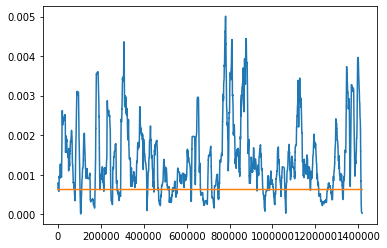

In [7]:
scene = '226_6'
file = dir_audio + scene + audio_extension
signal, fe = librosa.load(file, sr=samplerate, mono=True)

energy = (pd.Series(signal)**2).rolling(window=fe, min_periods=2, center=True).mean()

s = pd.Series(signal)
energy = (s**2).rolling(window=fe, min_periods=2, center=True).mean()
min_E = min(energy)
min_E = np.percentile(energy, 5)
plt.plot(energy)
f = 2
plt.plot([f * min_E] * len(energy))
plt.show()

# Make features

#### sur annotés :

In [6]:
ratedScenes = sorted(list(set(audio_only['doc'])))
df_features = pd.DataFrame(columns=['SCENE','SR','SNR','CONF','RECON','SCORE','XML'])
df_features = pd.read_csv('./data/audio_features.csv', sep='§', engine='python', index_col=0, encoding='utf-8')

In [7]:
df_features = make_audio_features(ratedScenes[0:40], df=df_features, method='speech', smooth='closing')
df_features.head()

extract_features 	 speech 	 closing
100_1 0.5732758620689655
extract_features 	 speech 	 closing
107_7 0.9435650378527185
extract_features 	 speech 	 closing
108_3 0.4657933042212518
extract_features 	 speech 	 closing
128_5 0.5968586387434555
extract_features 	 speech 	 closing
13_2 0.674074074074074
extract_features 	 speech 	 closing
147_1 0.8198307134220073
extract_features 	 speech 	 closing
148_4 0.20924574209245742
extract_features 	 speech 	 closing
165_10 0.7618483412322274
extract_features 	 speech 	 closing
180_4 0.7097242380261248
extract_features 	 speech 	 closing
186_2 0.5385906040268457
extract_features 	 speech 	 closing
190_10 0.7802197802197802
extract_features 	 speech 	 closing
197_7 0.8761726078799249
extract_features 	 speech 	 closing
199_9 0.7312252964426877
extract_features 	 speech 	 closing
19_13 0.7216721672167217
extract_features 	 speech 	 closing
208_12 0.9027777777777778
extract_features 	 speech 	 closing
210_3 0.6551077788191191
extract_features 	 spe

,SCENE,SR,SNR,CONF,RECON,SCORE,XML
0,100_1,0.634000,0.952384,0.889849,Bonsoir intérêt pour coiffeur c'est pas sérieu...,0.573276,Bonsoir Tu veux pas te garer Pour quoi faire M...
1,107_7,0.944506,0.998807,0.882336,pourquoi trouver la je vous en prie je vous in...,0.943565,Qu est ce qui se passe Vous en faites un bouca...
2,108_3,0.683847,0.934093,0.886411,pourrais-tu vous êtes totalement à côté de la ...,0.465793,Quoi Une chorale Oui Mon pauvre Mathieu vous ê...
3,128_5,0.689977,0.991269,0.876096,marquer comme les mises en clair normal en ham...,0.596859,T as remarqué comme les nuits sont claires Nor...
4,13_2,0.855560,0.702674,0.912446,dites-moi Monsieur pires la Lombardie vous ave...,0.674074,Dites moi monsieur Pire Tina Lombardi vous avi...


In [19]:
df_features.to_csv('./data/audio_features.csv', sep='§', encoding='utf-8')

In [9]:
ratedScenes = sorted(list(set(audio_only['doc'])))
df_features2 = pd.DataFrame(columns=['SCENE','SR','SNR','CONF','RECON','SCORE','XML'])
#df_features = pd.read_csv('./data/audio_features.csv', sep='§', engine='python', index_col=0, encoding='utf-8')
df_features2 = make_audio_features(ratedScenes[0:40], df=df_features2, method='speech', smooth='rolling_mean')

df_features2.to_csv('./data/audio_features2.csv', sep='§', encoding='utf-8')
df_features2.head()

extract_features 	 speech 	 rolling_mean
100_1 0.47737068965517243
extract_features 	 speech 	 rolling_mean
107_7 0.8513420509291122
extract_features 	 speech 	 rolling_mean
108_3 0.438136826783115
extract_features 	 speech 	 rolling_mean
128_5 0.5340314136125655
extract_features 	 speech 	 rolling_mean
13_2 0.4074074074074074
extract_features 	 speech 	 rolling_mean
147_1 0.49334945586457074
extract_features 	 speech 	 rolling_mean
148_4 0.20681265206812652
extract_features 	 speech 	 rolling_mean
165_10 0.5556872037914692
extract_features 	 speech 	 rolling_mean
180_4 0.5602322206095791
extract_features 	 speech 	 rolling_mean
186_2 0.62751677852349
extract_features 	 speech 	 rolling_mean
190_10 0.8104395604395604
extract_features 	 speech 	 rolling_mean
197_7 0.8123827392120075
extract_features 	 speech 	 rolling_mean
199_9 0.7035573122529645
extract_features 	 speech 	 rolling_mean
19_13 0.6523652365236524
extract_features 	 speech 	 rolling_mean
208_12 0.8148148148148148
extract_

,SCENE,SR,SNR,CONF,RECON,SCORE,XML
0,100_1,0.568055,0.947160,NaN,Bonsoir pourquoi faire tu es pas sérieux tu me...,0.477371,Bonsoir Tu veux pas te garer Pour quoi faire M...
1,107_7,0.890443,0.994624,0.883986,c'est normal parce que je suis en manuel sur l...,0.851342,Qu est ce qui se passe Vous en faites un bouca...
2,108_3,0.642262,0.933339,0.881525,vous êtes totalement à côté de la plaque chora...,0.438137,Quoi Une chorale Oui Mon pauvre Mathieu vous ê...
3,128_5,0.648102,0.991902,0.884452,marquer comme les mises en clair en regard de ...,0.534031,T as remarqué comme les nuits sont claires Nor...
4,13_2,0.808786,0.970325,NaN,dites-moi Monsieur pires vous avez sûrement un...,0.407407,Dites moi monsieur Pire Tina Lombardi vous avi...


In [16]:
df_features

,SCENE,SR,SNR,CONF,RECON,SCORE,XML
0,100_1,0.634000,0.952384,0.889849,Bonsoir intérêt pour coiffeur c'est pas sérieu...,0.573276,Bonsoir Tu veux pas te garer Pour quoi faire M...
1,107_7,0.944506,0.998807,0.882336,pourquoi trouver la je vous en prie je vous in...,0.943565,Qu est ce qui se passe Vous en faites un bouca...
2,108_3,0.683847,0.934093,0.886411,pourrais-tu vous êtes totalement à côté de la ...,0.465793,Quoi Une chorale Oui Mon pauvre Mathieu vous ê...
3,128_5,0.689977,0.991269,0.876096,marquer comme les mises en clair normal en ham...,0.596859,T as remarqué comme les nuits sont claires Nor...
4,13_2,0.855560,0.702674,0.912446,dites-moi Monsieur pires la Lombardie vous ave...,0.674074,Dites moi monsieur Pire Tina Lombardi vous avi...
5,147_1,0.833441,0.997311,0.920665,non je sais pas du tout ce que tu crois comme ...,0.819831,Non Jean Pierre c est pas du tout ce que tu cr...
6,148_4,0.616812,0.998676,0.882778,alors la leçon d'aujourd'hui Portet sur les fl...,0.209246,Asseyez vous Silence Bien Alors la leçon d auj...
7,165_10,0.940882,0.975748,0.837142,tu vas passer une mauvaise nuit apparemment la...,0.761848,On y va Je vous préviens qu il a passé une mau...
8,180_4,0.820951,0.985353,0.841919,oui ça sur place le problème en tout cas je pr...,0.709724,Oui Francis Leborgne Bah oui c est moi oui C e...
9,186_2,0.296766,0.886932,0.866736,crâne avec un an de plus que moi et maintenant...,0.538591,Toi qui crânais avec tes un an de plus que moi...


#### sur les autres data :

In [22]:
all_scenes = sorted(list(set(annot['doc'])))
scenes_chunks = [all_scenes[s:s+10] for s in range(0,len(all_scenes),10)]

df_features = pd.read_csv('./data/audio_features.csv', sep='§', engine='python', index_col=0, encoding='utf-8')

In [23]:
for scenes in scenes_chunks:
    df_features = make_audio_features(scenes, df=df_features, method='speech', smooth='closing')
    df_features.to_csv('./data/audio_features.csv', sep='§', encoding='utf-8')
    print(len(df_features), "/", len(all_scenes))

209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
209 / 300
281_13 0.9366715758468336
282_6 0.5867620751341681
283_14 0.386046511627907
284_6 0.516380655226209
285_2 0.6956521739130435
286_14 0.6005089058524173
287_8 0.250381679389313
288_13 0.5031645569620253
289_14 0.5105740181268882
28_2 0.43525741029641185
219 / 300
290_2 0.3350383631713555
292_1 0.4452380952380952
293_6 0.7912552891396333
294_13 0.6496865203761756
295_15 0.1279826464208243
296_8 0.15566037735849056
297_3 0.708
298_13 0.5485008818342152
299_6 0.4743162108072048
228 / 300
300_7 0.6031746031746031
30_11 0.6693333333333333
31_14 0.5997045790251108
32_13 0.8376068376068376
33_11 0.9121338912133892
34_3 0.6212121212121212
35_10 0.725925925925926
36_10 0.4895833333333333
236 / 300
37_11 0.2601279317697228
38_4 0.31118314424635335
39_1 0.4
3_5 0.8034682080924855
40_13 0.87341772151898

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:269: RuntimeWarning: Mean of empty slice.


71_7 1.0
272 / 300
73_6 0.8546603475513428
74_4 0.37122969837587005
75_6 0.21807747489239598
76_11 0.22811059907834103
77_11 0.2921719955898567
78_9 0.4885745375408052
7_1 0.8622908622908623
81_15 0.680168776371308
280 / 300
82_11 0.3865979381443299
83_14 0.45643153526970953
84_4 0.3464052287581699
85_6 0.3015463917525773
86_14 0.39057239057239057
87_2 0.2523719165085389
88_11 0.5583832335329342
89_2 0.20704845814977973
8_3 0.6885593220338984
90_15 0.4626865671641791
290 / 300
91_14 0.4715261958997722
92_4 0.38670284938941657
93_8 0.46153846153846156
94_2 0.7824858757062146
95_14 0.576
96_6 1.0
97_6 0.4194008559201141
98_13 0.3838582677165354
99_11 0.5323886639676113
9_1 0.6953955135773318
300 / 300


In [24]:
df_features.to_csv('./data/audio_features.csv', sep='§', encoding='utf-8')

In [25]:
df_features

,SCENE,SR,SNR,CONF,RECON,SCORE,XML
0,100_1,0.634000,0.952384,0.889849,Bonsoir intérêt pour coiffeur c'est pas sérieu...,0.573276,Bonsoir Tu veux pas te garer Pour quoi faire M...
1,107_7,0.944506,0.998807,0.882336,pourquoi trouver la je vous en prie je vous in...,0.943565,Qu est ce qui se passe Vous en faites un bouca...
2,108_3,0.683847,0.934093,0.886411,pourrais-tu vous êtes totalement à côté de la ...,0.465793,Quoi Une chorale Oui Mon pauvre Mathieu vous ê...
3,128_5,0.689977,0.991269,0.876096,marquer comme les mises en clair normal en ham...,0.596859,T as remarqué comme les nuits sont claires Nor...
4,13_2,0.855560,0.702674,0.912446,dites-moi Monsieur pires la Lombardie vous ave...,0.674074,Dites moi monsieur Pire Tina Lombardi vous avi...
...,...,...,...,...,...,...,...
295,96_6,0.984679,0.722159,NaN,,1.000000,Le voilà Monsieur de Bergerac Quel succès Quel...
296,97_6,0.797581,0.843505,0.892839,Adlene Drogba précieuses orphelines les cousin...,0.419401,Magdeleine Robin dite Roxane Fine précieuse Oh...
297,98_13,0.737091,0.953781,0.924298,une petite collation merci beaucoup madame vou...,0.383858,Voilà Une petite collation avant le dîner Merc...
298,99_11,0.727990,0.994941,0.908762,ça va sur la trouver c'est vrai si j'étais pas...,0.532389,Vous allez pas vous fâchez si je vous dis quel...


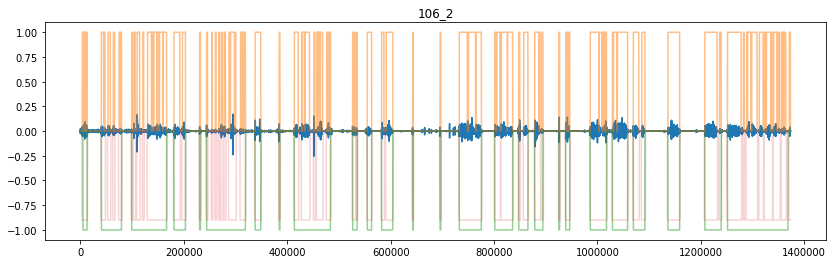

In [17]:
from scipy import ndimage

for scene in ["106_2"]:

    audiofile = dir_audio + scene + audio_extension

    # load data
    bin_signal, signal, fe = load_signal(audiofile, samplerate=samplerate)
    recomposed_signal = np.frombuffer(bin_signal, dtype=np.int16)
    
    agg = 3
    
    vad = webrtcvad.Vad()
    vad.set_mode(mode=agg)

    millisec = 10
    fenetre = int(samplerate * millisec * 2 / 1000)

    fen_speech = [vad.is_speech(bin_signal[m:m+fenetre], samplerate) 
                  for m in range(0,len(bin_signal),fenetre)
                 if len(bin_signal[m:m+fenetre]) == fenetre]

    widened_speech = np.array([[s] * int(fenetre/2) for s in fen_speech]).ravel()
    speech = np.full(len(recomposed_signal), widened_speech[-1])
    speech[0:len(widened_speech)] = widened_speech
    
    smoothed_speech = pd.Series(speech).rolling(window=int(samplerate/5), min_periods=2, center=True).mean() > 0.2
    res = pd.Series(ndimage.binary_closing(input=speech, structure=np.array([1]*10000)).astype(bool))

    plt.figure(figsize=(14,4))
    plt.title(scene)
    plt.plot(signal)
    plt.plot(speech, alpha=0.5)
    plt.plot(res*-1, alpha=0.5)
    plt.plot(smoothed_speech*-0.9, alpha=0.2)
    plt.show()